In [1]:



import logging
import random
import sys
sys.path.append('/data/tillson/llm-project/SimPO/scripts')

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


import torch
import transformers
from transformers import AutoModelForCausalLM, set_seed

from alignment import (
    DataArguments,
    DPOConfig,
    H4ArgumentParser,
    ModelArguments,
    get_checkpoint,
    get_datasets,
    get_kbit_device_map,
    get_peft_config,
    get_quantization_config,
    get_tokenizer,
    is_adapter_model,
)
from alignment.data import maybe_insert_system_message, is_openai_format
from peft import PeftConfig, PeftModel
# from simpo_trainer import SimPOTrainer




# from simpo_config import SimPOConfig
from dataclasses import dataclass, field
from typing import Optional, Literal


import seaborn as sns
import matplotlib.pyplot as plt


/data/tillson/conda-envs/simpo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from accelerate import Accelerator
from transformers import HfArgumentParser
from scripts import simpo_config
@dataclass
class TestConfig:
    task: str = ""
parser = HfArgumentParser((ModelArguments, DataArguments, simpo_config.SimPOConfig, TestConfig))
model_args, data_args, simpo_config, _ = parser.parse_yaml_file(yaml_file="training_configs/mistral-7b-base-simpo.yaml")


/data/tillson/conda-envs/simpo/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
def get_texts(row):
    return { 
        "prompt": row["prompt"],
        "chosen": row["chosen"][-1]["content"],
        "rejected": row["rejected"][-1]["content"],
    }

raw_datasets = get_datasets(
    data_args,
    splits=data_args.dataset_splits,
    configs=data_args.dataset_configs,
    columns_to_keep=["messages", "chosen", "rejected", "prompt", "completion", "label"],
    # seed=training_args.seed,
)#.map(get_texts, num_proc=8)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'messages'],
        num_rows: 611
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'messages'],
        num_rows: 2000
    })
})

In [6]:
import pandas as pd
df = pd.DataFrame(raw_datasets["train"])

In [8]:
df

,prompt,chosen,rejected,messages
0,how to add an embedding chatbot to a streamlit...,To add an embedding chatbot to your Streamlit ...,To add an embedding chatbot to a Streamlit app...,[{'content': 'how to add an embedding chatbot ...
1,What does an aromatic herb release? Natural ga...,An aromatic herb releases volatile oils which ...,An aromatic herb typically releases volatile c...,[{'content': 'What does an aromatic herb relea...
2,"In addition to the given prompt, please includ...","Based on the given prompt, and with regards to...",Hello! I'm an AI assistant here to help you wi...,"[{'content': 'In addition to the given prompt,..."
3,"""Using scientific evidence and industry report...",Carbon capture technologies play a crucial rol...,Carbon capture technologies can play a critica...,"[{'content': '""Using scientific evidence and i..."
4,I want you to explain me the concepts in easy ...,Machine learning is the process of training a ...,Of course! I'm here to help explain complex co...,[{'content': 'I want you to explain me the con...
...,...,...,...,...
606,"In this task, you are given inputs i and A, wh...","3301, 9207, S, 9591\nConfidence: 100%","3301, 9207, S, 9591, k, z, x, e","[{'content': 'In this task, you are given inpu..."
607,"Given a sentence in French, generate a new Fre...","Si vous voulez écouter de la musique en file, ...",Here is some relevant information regarding Gu...,"[{'content': 'Given a sentence in French, gene..."
608,A text is given in Panjabi. Translate it from ...,Confidence: 90%,"I can't satisfy your request, I'm just an AI, ...",[{'content': 'A text is given in Panjabi. Tran...
609,Estimate the height of the world's tallest peak.,"The world's tallest peak is Mount Everest, whi...",Mount Everest stands at an estimated height of...,[{'content': 'Estimate the height of the world...


In [51]:
df["chosen_len"] = df["chosen"].apply(len)
df["rejected_len"] = df["rejected"].apply(len)

<Axes: xlabel='value', ylabel='Proportion'>

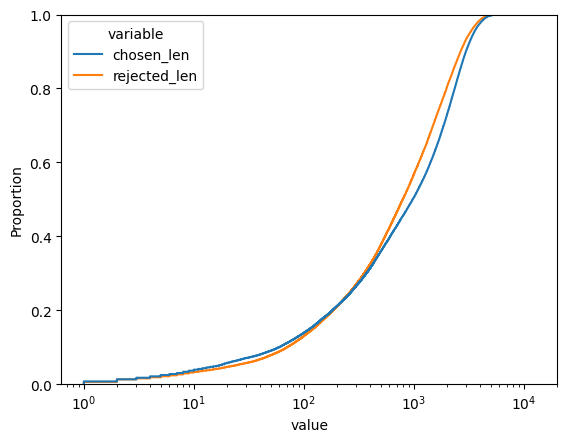

In [60]:
melted = df.melt(value_vars=["chosen_len", "rejected_len"])
sns.ecdfplot(melted, x="value", hue="variable", log_scale=True)

In [10]:
tokenizer = get_tokenizer(model_args, data_args)

raw_datasets = raw_datasets.map(
    apply_chat_template,
    fn_kwargs={
        "tokenizer": tokenizer,
        "task": "simpo",
        "auto_insert_empty_system_msg": data_args.auto_insert_empty_system_msg,
        "change_template": "mistral",
    },
    num_proc=8,
    remove_columns=column_names,
    desc="Formatting comparisons with prompt template",
)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def extract_lengths(example):
    return {
        "text_prompt": len(example["text_prompt"]),
        "text_chosen": len(example["text_chosen"]),
        "text_rejected": len(example["text_rejected"]),
    }

dataset_lengths = raw_datasets.map(
    extract_lengths,
    num_proc=8,
    desc="Reducing data entries to lengths for ranking",
)

train_lengths = dataset_lengths["train"]
test_lengths = dataset_lengths["test"]



Reducing data entries to lengths for ranking (num_proc=8):   0%|          | 0/61135 [00:00<?, ? examples/s]


KeyError: 'text_prompt'

In [12]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_shuffled_dataset(raw_datasets)

Flattening the indices: 100%|██████████| 2000/2000 [00:00<00:00, 29879.49 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 61135
    })
    test: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 2000
    })
})

In [19]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 61135
    })
    test: Dataset({
        features: ['text_prompt', 'text_chosen', 'text_rejected'],
        num_rows: 2000
    })
})

In [11]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_shuffled_dataset(raw_datasets)

Flattening the indices:   0%|          | 0/305 [00:00<?, ? examples/s]

Flattening the indices: 100%|██████████| 2000/2000 [00:00<00:00, 5439.42 examples/s]


DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'messages'],
        num_rows: 305
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'messages'],
        num_rows: 2000
    })
})

In [23]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_length_sorted(raw_datasets)["train"][0]

Map (num_proc=8): 100%|██████████| 305/305 [00:00<00:00, 1460.80 examples/s]


KeyError: 'text_chosen'

In [39]:
import importlib
import ranking
importlib.reload(ranking)

ranking.get_complexity_sorted(raw_datasets)["train"][0]

InvalidParameterError: The 'strip_accents' parameter of TfidfVectorizer must be a str among {'ascii', 'unicode'}, None or a callable. Got True instead.

In [22]:
ranking.get_complexity_sorted(raw_datasets)

Computing complexity for train set (num_proc=8): 100%|██████████| 611/611 [00:01<00:00, 598.65 examples/s]


DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'messages', 'text_prompt_complexity', 'text_chosen_complexity', 'text_rejected_complexity'],
        num_rows: 305
    })
    test: Dataset({
        features: ['prompt', 'chosen', 'rejected', 'messages'],
        num_rows: 2000
    })
})

In [18]:
raw_datasets["train"]["chosen"]

['To add an embedding chatbot to your Streamlit app, you can use the `st.html` function to render an iframe that contains the chatbot. Here\'s an example:\n```\nimport streamlit as st\n\nst.title("Your business insights in all data starts here")\nst.sidebar.title("Navigation")\npage = st.sidebar.radio("Select a page:", options=["Main", "Q&A", "Search"])\n\nif page == "Main":\n    main_page()\nelif page == "Q&A":\n    qa_page()\nelif page == "Search":\n    search_page()\n\nif st.sidebar.button("Open Chatbot"):\n    st.sidebar.markdown("""\n    <iframe height="600" style="width: 100%;" scrolling="no" title="Chatbot" src="https://example.com/chatbot" frameborder="no" loading="lazy" allowtransparency="true" allowfullscreen="true"></iframe>\n    """, unsafe_allow_html=True)\n```\nReplace `"https://example.com/chatbot"` with the URL of your chatbot\'s iframe embed code. You can get this code from the provider of your chatbot platform.\n\nYou can also use the `st.sidebar.subheader` function t

In [13]:
# pd.DataFrame(train_complexity)

In [14]:
# lengths_df

In [32]:
# Convert train and test datasets to DataFrame
train_df = pd.DataFrame(train_lengths)
train_df["set"] = "train"
test_df = pd.DataFrame(test_lengths)
test_df["set"] = "test"

# Combine train and test data
lengths_df = pd.concat([train_df, test_df])

# Plot CDFs using subplots for text_prompt, text_chosen, and text_rejected
fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=True, constrained_layout=True)
text_types = ["text_prompt", "text_chosen", "text_rejected"]
titles = ["Prompts", "Chosen response", "Rejected response"]

# Plot lengths CDF
for i, text_type in enumerate(text_types):
    sns.ecdfplot(
        data=lengths_df, 
        x=text_type, 
        hue="set", 
        ax=axes[0, i]
    )
    axes[0, i].set_title(titles[i])
    axes[0, i].set_xlabel("")
    axes[0, i].set_ylabel("CDF")
    axes[0, i].set_xscale("log")
    axes[0, i].set_xlim(1, 10**4)

    if i == 2:  # Add 'Length' label to the right
        axes[0, i].annotate(
            "Length", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )

# Convert train and test datasets to DataFrame
train_df = pd.DataFrame(train_complexity)
train_df["set"] = "train"
test_df = pd.DataFrame(test_complexity)
test_df["set"] = "test"

# Combine train and test data
complexity_df = pd.concat([train_df, test_df])

# Plot complexity CDF
for i, text_type in enumerate(text_types):
    sns.ecdfplot(
        data=complexity_df, 
        x=text_type, 
        hue="set", 
        ax=axes[1, i]
    )
    axes[1, i].set_title("")
    axes[1, i].set_xlabel("")
    axes[1, i].set_ylabel("CDF")

    if i == 2:  # Add 'Complexity' label to the right
        axes[1, i].annotate(
            "Complexity", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )

# # Move legend to the right-hand side of the figure
# handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(
#     handles, 
#     labels, 
#     loc="center right", 
#     bbox_to_anchor=(1.15, 0.5), 
#     title="Set", 
#     frameon=False
# )

# Add padding to the left
# plt.subplots_adjust(left=0.1)

# Save or show the plot
plt.savefig("figs/cdf_of_data_with_labels_and_legend.pdf")
plt.show()


NameError: name 'pd' is not defined

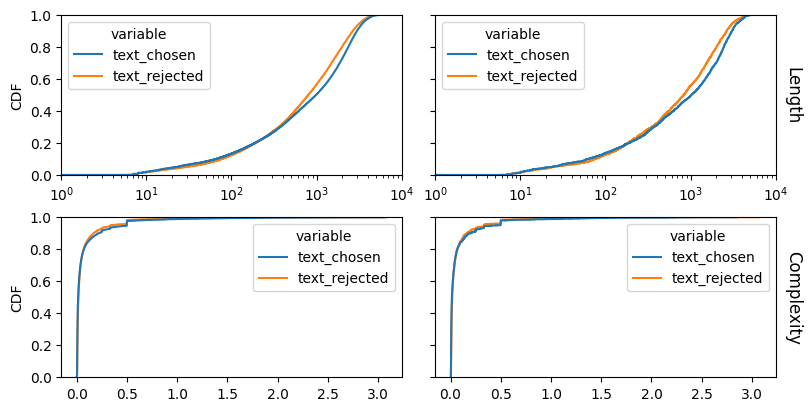

In [16]:
# Convert train and test datasets to DataFrame
train_length_df = pd.DataFrame(train_lengths)
train_length_df["set"] = "train"
test_length_df = pd.DataFrame(test_lengths)
test_length_df["set"] = "test"


train_complexity_df = pd.DataFrame(train_complexity)
train_complexity_df["set"] = "train"
test_complexity_df = pd.DataFrame(test_complexity)
test_complexity_df["set"] = "test"

# test_lengths["set"] = "test"
# train_complexity["set"] = "train"
# test_complexity["set"] = "test"

# Combine lengths and complexity datasets
lengths_df = pd.concat([train_length_df, test_length_df])
lengths_df = lengths_df.melt(id_vars=["set"], value_vars=["text_chosen", "text_rejected"])
complexity_df = pd.concat([train_complexity_df, test_complexity_df])
complexity_df = complexity_df.melt(id_vars=["set"], value_vars=["text_chosen", "text_rejected"])

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharey=True, constrained_layout=True)

# Plot lengths CDF for training and testing
for i, data_set in enumerate(["train", "test"]):    
    sns.ecdfplot(
        data=lengths_df[lengths_df["set"] == data_set], 
        x="value", 
        hue="variable", 
        ax=axes[0, i]
    )
    axes[0, i].set_title("")
    axes[0, i].set_xlabel("")
    axes[0, i].set_ylabel("CDF" if i == 0 else "")
    axes[0, i].set_xscale("log")
    axes[0, i].set_xlim(1, 10**4)
    # axes[0, i].legend(title="Type", frameon=False)

    if i == 1:  # Add 'Length' label to the right
        axes[0, i].annotate(
            "Length", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )


# Plot complexity CDF for training and testing
for i, data_set in enumerate(["train", "test"]):
    sns.ecdfplot(
        data=complexity_df[complexity_df["set"] == data_set], 
        x="value", 
        hue="variable", 
        ax=axes[1, i]
    )
    axes[1, i].set_title("")
    axes[1, i].set_xlabel("")
    axes[1, i].set_ylabel("CDF" if i == 0 else "")
    # axes[1, i].legend(title="Type", frameon=False)

    if i == 1:  # Add 'Length' label to the right
        axes[1, i].annotate(
            "Complexity", 
            xy=(1.05, 0.5), 
            xycoords='axes fraction', 
            rotation=-90, 
            fontsize=12, 
            ha='center', 
            va='center'
        )


# Save or show the plot
plt.savefig("figs/cdf_of_data_with_train_test_comparison.pdf")
plt.show()


In [17]:
complexity_df

,set,variable,value
0,train,text_chosen,0.012426
1,train,text_chosen,0.045777
2,train,text_chosen,0.020198
3,train,text_chosen,1.528025
4,train,text_chosen,0.028362
...,...,...,...
126265,test,text_rejected,0.007502
126266,test,text_rejected,0.091290
126267,test,text_rejected,0.007833
126268,test,text_rejected,1.079241


In [18]:
lengths_df.groupby(["set", "variable"])["value"].describe()

count         mean          std  min    25%     50%  \
set   variable                                                               
test  text_chosen     2000.0  1340.141000  1193.923822  7.0  288.0  1024.0   
      text_rejected   2000.0  1135.156500  1043.977804  6.0  251.5   831.5   
train text_chosen    61135.0  1301.021346  1168.501140  6.0  277.0   987.0   
      text_rejected  61135.0  1126.544614  1044.744491  6.0  271.0   803.0   

                         75%      max  
set   variable                         
test  text_chosen    2241.50   5209.0  
      text_rejected  1772.25   5108.0  
train text_chosen    2116.00  12609.0  
      text_rejected  1734.00   8267.0

In [19]:
lengths_df.melt(id_vars=["set"], value_vars=["text_chosen", "text_rejected"])

ValueError: value_name (value) cannot match an element in the DataFrame columns.

In [49]:
complexity_df

,set,variable,value
0,train,text_chosen,2.385733
1,train,text_chosen,2.655094
2,train,text_chosen,4.544635
3,train,text_chosen,3.056051
4,train,text_chosen,2.382381
...,...,...,...
126265,test,text_rejected,2.385538
126266,test,text_rejected,2.556126
126267,test,text_rejected,2.491041
126268,test,text_rejected,4.316966


In [20]:
plt.show()

In [47]:
complexity_df

,set,variable,value
0,train,text_chosen,2.385733
1,train,text_chosen,2.655094
2,train,text_chosen,4.544635
3,train,text_chosen,3.056051
4,train,text_chosen,2.382381
...,...,...,...
126265,test,text_rejected,2.385538
126266,test,text_rejected,2.556126
126267,test,text_rejected,2.491041
126268,test,text_rejected,4.316966


In [22]:
# # Convert train and test datasets to DataFrame
# train_df = pd.DataFrame(train_complexity)
# train_df["set"] = "train"
# test_df = pd.DataFrame(test_complexity)
# test_df["set"] = "test"

# Combine train and test data
complexity_df = pd.concat([train_df, test_df])


for i, text_type in enumerate(text_types):
    sns.ecdfplot(
        data=complexity_df, 
        x=text_type, 
        hue="set", 
        ax=axes[1, i]
    )
    axes[1, i].set_title(titles[i])
    axes[1, i].set_xlabel("Length")
    axes[1, i].set_ylabel("CDF")
    # axes[1, i].set_xscale("log")
    # axes[1, i].set_xlim(1, 10**4)



plt.tight_layout()
# plt.show()
# plt.savefig("figs/cdf_of_data.pdf")
plt.show()


<Figure size 640x480 with 0 Axes>

In [23]:
raw_datasets["test"]

Dataset({
    features: ['text_prompt', 'text_chosen', 'text_rejected'],
    num_rows: 2000
})

In [24]:
for x in dataset_lengths["train"]

SyntaxError: expected ':' (2642744887.py, line 1)